# Comparison

Comparison of the Seapodym-LMTL model without transport (U/V fields have been set to zero) and the Seapodym-LMTL model.


In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from matplotlib import pyplot as plt

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

In [ ]:
import pint

pint.application_registry("day").to("hour").magnitude

## Loading the data

---


In [ ]:
path_forcing = "../data/phd/SEAPODYM_LMTL/2024-12-13_-_Constant_fields_no_transport/data/data*.nc"

forcing = xr.open_mfdataset(path_forcing).load()
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing["depth"].attrs = {"axis": "Z"}
forcing["latitude"].attrs = {"axis": "Y"}
forcing["longitude"].attrs = {"axis": "X"}
forcing["time"].attrs = {"axis": "T"}
forcing

In [ ]:
path_obs = "../data/phd/SEAPODYM_LMTL/2024-12-13_-_Constant_fields_no_transport/output/*biomass*.nc"

observation = xr.open_mfdataset(path_obs).load()
observation

WARNING : We have a difference in term of calendar. SeapoDym-LMTL use 30 days month and 360 days year. SeapoDym-LMTL use 31 days month and 365 days year.


In [ ]:
day_layer = 0
night_layer = 0
tr_max = 10.38
tr_rate = -0.11
inv_lambda_max = 150
inv_lambda_rate = -0.15

f_groups = FunctionalGroups(
    functional_groups=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalGroupUnitRelationParameters(
                inv_lambda_max=inv_lambda_max,
                inv_lambda_rate=inv_lambda_rate,
                temperature_recruitment_rate=tr_rate,
                cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                temperature_recruitment_max=tr_max,
            ),
            energy_transfert=0.1668,
        )
    ]
)

p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=0.08333, timestep=1),
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    kernel_parameters=KernelParameters(compute_preproduction=True),
)
zooplankton_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))

In [6]:
zooplankton_model.run()

In [ ]:
zooplankton_model.state

## Comparison

---


### 1.a. Convert obs and pred data to comparable units


In [8]:
obs_biomass = observation["zpk_epi"].pint.quantify().pint.dequantify()
obs_biomass = obs_biomass.assign_coords({"time": obs_biomass.indexes["time"].ceil("D")})

In [9]:
pred_biomass = zooplankton_model.export_biomass()
pred_biomass = pred_biomass.pint.quantify().pint.to("g m^-2").pint.dequantify().sel(functional_group=0)

### 1.b. Same for the production


In [10]:
obs_recruited = xr.open_mfdataset(
    "../data/phd/SEAPODYM_LMTL/2024-12-13_-_Constant_fields_no_transport/output/*recprod*.nc"
).load()

In [11]:
pred_recruited = (
    zooplankton_model.state.recruited.pint.quantify().pint.to("g day-1 m^-2").pint.dequantify().sel(functional_group=0)
)

In [12]:
longitude_slice = slice(None, None)
mean_over_time = pd.DataFrame(
    {
        "obs": obs_recruited.zpk_epi_recprod.sel(longitude=longitude_slice).mean(["latitude", "longitude"]),
        "pred": pred_recruited.sel(longitude=longitude_slice).mean(["latitude", "longitude"]),
    },
    index=obs_biomass.time,
).reset_index(names="time")

In [ ]:
px.line(
    mean_over_time,
    x="time",
    y=["obs", "pred"],
    title="Observed biomass",
    labels={"x": "Time", "y": "Biomass (g m^-2)"},
).show()

### 2. Calculate the error metrics


In [14]:
longitude_slice = slice(None, None)
mean_over_time = pd.DataFrame(
    {
        "obs": obs_biomass.sel(longitude=longitude_slice).mean(["latitude", "longitude"]),
        "pred": pred_biomass.sel(longitude=longitude_slice).mean(["latitude", "longitude"]),
    },
    index=obs_biomass.time,
).reset_index(names="time")

In [ ]:
px.line(
    mean_over_time,
    x="time",
    y=["obs", "pred"],
    title="Observed biomass",
    labels={"x": "Time", "y": "Biomass (g m^-2)"},
).show()

WARNING : In SeapoPym, the biomass seems to decrease faster than in SeapoDym-LMTL.


In [ ]:
# diff = (
#     np.abs(obs_biomass.sel(longitude=longitude_slice) - pred_biomass.sel(longitude=longitude_slice)) / obs_biomass * 100
# )
# # time_slice = slice("2000-03", None)
# # time_slice = slice(None, None)
# time_slice = slice(None, "2000-03")

# # px.imshow(
# #     diff.sel(time=time_slice).mean("time"),
# #     title="Mean relative difference (%)",
# #     color_continuous_scale="reds",
# # ).show()
# px.imshow(
#     diff.sel(time=time_slice),
#     animation_frame="time",
#     title="Relative difference (%)",
#     # range_color=[0, 20],
# ).show()

In [ ]:
mean = diff.mean(["latitude", "longitude"])
min = diff.min(["latitude", "longitude"])
max = diff.max(["latitude", "longitude"])

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=diff.time, y=min, fill=None, mode="lines", line_color="green", name="min"),
)
fig.add_trace(
    go.Scatter(x=diff.time, y=mean, fill="tonexty", mode="lines", line_color="orange", name="mean (10 days windows)")
)
fig.add_trace(go.Scatter(x=diff.time, y=max, fill="tonexty", mode="lines", line_color="red", name="max"))
fig.update_layout(title="Relative difference (%)", xaxis_title="Time", yaxis_title="Relative difference (%)")
fig.show()

## Difference between float32 and float64.

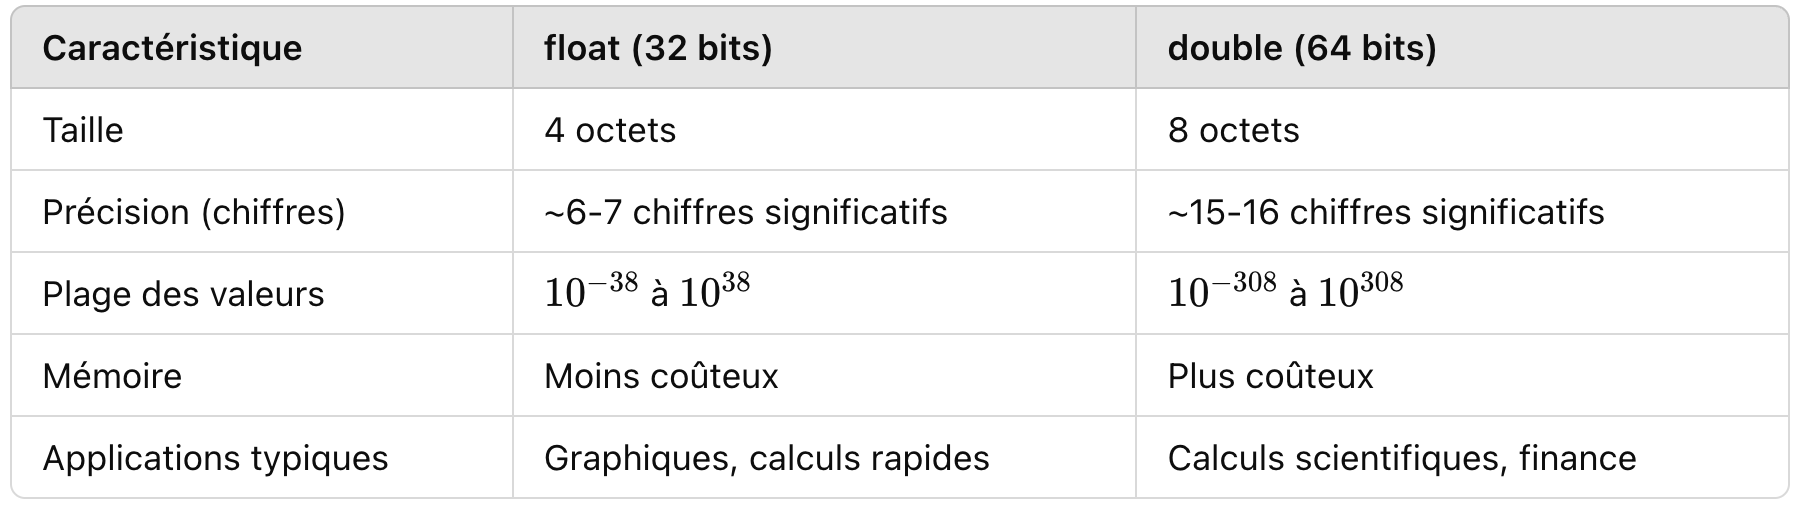
